In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sn
from datetime import date
from scipy.stats import chi2_contingency
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy.signal import find_peaks
from statsmodels.stats.diagnostic import acorr_ljungbox

C:\Users\imuba\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\imuba\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
#reading csv file
df= pd.read_csv("INVISTA_EAD_3.csv")

In [3]:
df.head(5)

,CREATE_DATE,COMPANY_CODE_ID,VENDOR_ID,POSTAL_CD,RELEASE_DATE,MATERIAL_ID,SUB_COMMODITY_DESC,MRP_TYPE_ID,MRP_TYPE_DESC_E,PLANT_ID,POR_DELIVERY_DATE,FIRST_GR_POSTING_DATE,DELIVERY_DATE,REQUESTED_DELIVERY_DATE,PLANNED_DELIVERY_DAYS,BI_LAST_UPDATED_PURCHASE_DOCUMENT_ITEM
0,2018-09-07,CN15,V4014,29078,NaN,2.100008e+09,Custom Manufacturing,1.0,1.0,1016.0,2018-11-28,2018-11-22,2018-11-16,2018-11-16,52.0,2023-05-30
1,2018-09-07,CN20,8010095928,201206,NaN,NaN,Tanks and Process Equipment,NaN,NaN,1032.0,NaN,NaN,2018-09-28,2018-09-28,0.0,2023-05-30
2,2018-09-07,CA10,8010003146,L6L 6R2,NaN,1.100126e+09,Piping & Tubing,1.0,1.0,4036.0,NaN,2018-12-05,2018-11-12,2018-10-01,24.0,2023-05-30
3,2018-09-07,CA10,8010005836,N2C 0B7,NaN,NaN,Material Handling,NaN,NaN,4036.0,2018-09-07,2018-09-18,2018-09-08,2018-09-08,0.0,2023-05-30
4,2018-09-07,CA10,8010005836,N2C 0B7,NaN,NaN,Material Handling,NaN,NaN,4036.0,2018-09-07,2018-09-18,2018-09-08,2018-09-08,0.0,2023-05-30


In [4]:
#droping unneccessary columns
df = df.drop(columns = ['RELEASE_DATE','MRP_TYPE_ID', 'MRP_TYPE_DESC_E', 'PLANNED_DELIVERY_DAYS'])

In [5]:
#seeing the datatypes
df.dtypes

CREATE_DATE                                object
COMPANY_CODE_ID                            object
VENDOR_ID                                  object
POSTAL_CD                                  object
MATERIAL_ID                               float64
SUB_COMMODITY_DESC                         object
PLANT_ID                                  float64
POR_DELIVERY_DATE                          object
FIRST_GR_POSTING_DATE                      object
DELIVERY_DATE                              object
REQUESTED_DELIVERY_DATE                    object
BI_LAST_UPDATED_PURCHASE_DOCUMENT_ITEM     object
dtype: object

# Dealing With MATERIAL ID

In [6]:
#checking the null values of Material ID column
df['MATERIAL_ID'].isnull().sum()

520519

In [7]:
'''
As material id is associated with sub commodity, we group material id with sub commodity and impute the most frequent
material id of each group in null values.
'''
def impute_most_frequent(group):
    if group['MATERIAL_ID'].notna().any():
        most_frequent = group['MATERIAL_ID'].value_counts().idxmax()
        group['MATERIAL_ID'].fillna(most_frequent, inplace=True)
    else:
        pass
    return group
df = df.groupby('SUB_COMMODITY_DESC').apply(impute_most_frequent)

In [8]:
# checking null values after imputation
df['MATERIAL_ID'].isnull().sum()

21945

In [9]:
#checking unique value
df['MATERIAL_ID'].nunique()

41585

In [10]:
df.shape

(1088400, 12)

In [11]:
# deleting the null values of material id
df = df[~df['MATERIAL_ID'].isnull()]

In [12]:
df.shape

(1066455, 12)

# Changing the Data Type

In [13]:
df.dtypes

CREATE_DATE                                object
COMPANY_CODE_ID                            object
VENDOR_ID                                  object
POSTAL_CD                                  object
MATERIAL_ID                               float64
SUB_COMMODITY_DESC                         object
PLANT_ID                                  float64
POR_DELIVERY_DATE                          object
FIRST_GR_POSTING_DATE                      object
DELIVERY_DATE                              object
REQUESTED_DELIVERY_DATE                    object
BI_LAST_UPDATED_PURCHASE_DOCUMENT_ITEM     object
dtype: object

In [14]:
df.columns

Index(['CREATE_DATE', 'COMPANY_CODE_ID', 'VENDOR_ID', 'POSTAL_CD',
       'MATERIAL_ID', 'SUB_COMMODITY_DESC', 'PLANT_ID', 'POR_DELIVERY_DATE',
       'FIRST_GR_POSTING_DATE', 'DELIVERY_DATE', 'REQUESTED_DELIVERY_DATE',
       'BI_LAST_UPDATED_PURCHASE_DOCUMENT_ITEM'],
      dtype='object')

In [15]:
#defining categorical columns and date columns
date_column = ['CREATE_DATE', 'POR_DELIVERY_DATE', 'FIRST_GR_POSTING_DATE', 'DELIVERY_DATE', 'REQUESTED_DELIVERY_DATE', 
               'BI_LAST_UPDATED_PURCHASE_DOCUMENT_ITEM']
string_column = ['COMPANY_CODE_ID', 'VENDOR_ID', 'POSTAL_CD', 'PLANT_ID', 'MATERIAL_ID', 'SUB_COMMODITY_DESC']

In [16]:
# transforming data type to date time
for column in date_column:
    df[column] = pd.to_datetime(df[column], format = '%Y-%m-%d')

In [17]:
#change the data type to string
for column in string_column:
    df[column] = df[column].astype('str')

In [18]:
df.dtypes

CREATE_DATE                               datetime64[ns]
COMPANY_CODE_ID                                   object
VENDOR_ID                                         object
POSTAL_CD                                         object
MATERIAL_ID                                       object
SUB_COMMODITY_DESC                                object
PLANT_ID                                          object
POR_DELIVERY_DATE                         datetime64[ns]
FIRST_GR_POSTING_DATE                     datetime64[ns]
DELIVERY_DATE                             datetime64[ns]
REQUESTED_DELIVERY_DATE                   datetime64[ns]
BI_LAST_UPDATED_PURCHASE_DOCUMENT_ITEM    datetime64[ns]
dtype: object

### Dealing with postal code

In [19]:
#removing space from the postal code
df['POSTAL_CD'] = df['POSTAL_CD'].str.strip()

In [20]:
contains_space = df['POSTAL_CD'].str.contains(' ')
contains_two_words = df['POSTAL_CD'].str.split().str.len() == 2
print(f'The POSTAL_CD column has {contains_space.sum()} value with space')
print(f'The POSTAL_CD column has {contains_two_words.sum()} value with two word')

The POSTAL_CD column has 290816 value with space
The POSTAL_CD column has 290812 value with two word


In [21]:
# Split the 'POSTAL_CD' column by hyphen ('-') and keep the first part (part before the hyphen)
df['POSTAL_CD'] = df['POSTAL_CD'].str.split('-').str[0]

In [22]:
#removing space from postal code
df['POSTAL_CD'] = df['POSTAL_CD'].str.replace(' ', '')

In [23]:
#checking unique values in postal code
df['POSTAL_CD'].nunique()

3753

### SUB_COMMODITY_DESC

In [24]:
#deleting comas from SUB_COMMODITY_DESC
df['SUB_COMMODITY_DESC'] = df['SUB_COMMODITY_DESC'].str.replace(',', '')

In [25]:
# deleting 'and' from SUB_COMMODITY_DESC
df['SUB_COMMODITY_DESC'] = df['SUB_COMMODITY_DESC'].str.replace('and', '')

In [26]:
# deleting '&' from SUB_COMMODITY_DESC
df['SUB_COMMODITY_DESC'] = df['SUB_COMMODITY_DESC'].str.replace('&', '')

In [27]:
#removing space from  SUB_COMMODITY_DESC
df['SUB_COMMODITY_DESC'] = df['SUB_COMMODITY_DESC'].str.strip()
df['SUB_COMMODITY_DESC'] = df['SUB_COMMODITY_DESC'].str.replace(' ', '')

In [28]:
# checking unique values
df['SUB_COMMODITY_DESC'].nunique()

53

### POR_DELIVERY_DATE

In [29]:
#filling the null values of POR_DELIVERY_DATE with REQUESTED_DELIVERY_DATE
df['POR_DELIVERY_DATE'].fillna(df['REQUESTED_DELIVERY_DATE'], inplace=True)

# Missing Value

In [30]:
missing_value = df.isnull().sum()
missing_value

CREATE_DATE                                    0
COMPANY_CODE_ID                                0
VENDOR_ID                                      0
POSTAL_CD                                      0
MATERIAL_ID                                    0
SUB_COMMODITY_DESC                             0
PLANT_ID                                       0
POR_DELIVERY_DATE                          45283
FIRST_GR_POSTING_DATE                     160734
DELIVERY_DATE                              45269
REQUESTED_DELIVERY_DATE                    45299
BI_LAST_UPDATED_PURCHASE_DOCUMENT_ITEM         0
dtype: int64

In [31]:
# checking the percentage of missing values in each column
missing_percentage = (missing_value/len(df))*100
missing_percentage_df = pd.DataFrame({'Column': missing_percentage.index, 'Missing Percentage': missing_percentage.values})
print(missing_percentage_df.to_string(index=False))

                                Column  Missing Percentage
                           CREATE_DATE            0.000000
                       COMPANY_CODE_ID            0.000000
                             VENDOR_ID            0.000000
                             POSTAL_CD            0.000000
                           MATERIAL_ID            0.000000
                    SUB_COMMODITY_DESC            0.000000
                              PLANT_ID            0.000000
                     POR_DELIVERY_DATE            4.246124
                 FIRST_GR_POSTING_DATE           15.071803
                         DELIVERY_DATE            4.244811
               REQUESTED_DELIVERY_DATE            4.247624
BI_LAST_UPDATED_PURCHASE_DOCUMENT_ITEM            0.000000


In [32]:
#Deleting columns with high null value
columns_to_delete = ['FIRST_GR_POSTING_DATE']
df = df.drop(columns=columns_to_delete)

In [33]:
#droping the null values
df = df.dropna().copy()

In [34]:
df.shape

(1021156, 11)

In [35]:
# deleting null/'nan' values from VENDOR ID
null_vendor = df['VENDOR_ID'].str.contains('nan').sum()
print("Total null values in Vendor Id", null_vendor)
df = df[~df.isin(['nan']).any(axis=1)]

Total null values in Vendor Id 148029


In [36]:
df.shape

(871797, 11)

### Droping the values which are out of range

In [37]:
#date range
start_date = pd.to_datetime('2018-09-07')
end_date = pd.to_datetime('2023-09-07')

In [38]:
#defining a function to delete out of range date
def filter_by_date(df, start_date, end_date, columns):
    mask = True
    for col in columns:
        mask &= (df[col] >= start_date) & (df[col] <= end_date)
    return df[mask].copy()

# deleting the out of range values
date_columns = ['POR_DELIVERY_DATE', 'DELIVERY_DATE', 'REQUESTED_DELIVERY_DATE']
df = filter_by_date(df, start_date, end_date, date_columns)

In [39]:
#checking the range of date
min_date = df['DELIVERY_DATE'].min()
max_date = df['DELIVERY_DATE'].max()

# Print the range of dates
print(f"Minimum Date: {min_date}")
print(f"Maximum Date: {max_date}")

Minimum Date: 2018-09-07 00:00:00
Maximum Date: 2023-09-07 00:00:00


In [40]:
df.shape

(861549, 11)

# Feature Engineering

### DELIVERY_STATUS

We are introducing a new feature called 'DELIVERY STATUS,' which aims to indicate whether the vendor's material delivery was delayed or not. This determination is based on a comparison between the 'POR_DELIVERY_DATE' and the 'DELIVERY_DATE.' If the 'DELIVERY_DATE' is greater than the 'POR_DELIVERY_DATE,' the 'DELIVERY_STATUS' will be marked as 'late,' denoted by the value 1. Otherwise, if the 'DELIVERY_STATUS' is 'on time' or 'early,' it will be represented by the value 0.

In [41]:
# creating new feature Delivery_Status
df['Delivery_Status'] = np.where(df['DELIVERY_DATE'] > df['POR_DELIVERY_DATE'], 1, 0)

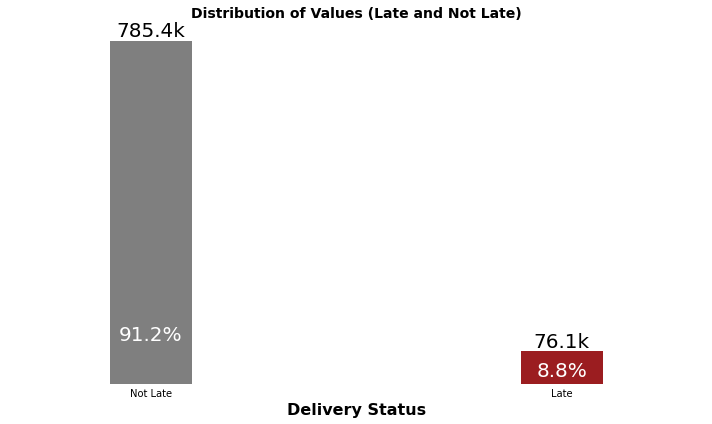

In [42]:
# Calculate value counts for 'Delivery_Status'
value_counts = df['Delivery_Status'].value_counts()
value_counts_in_thousand = value_counts / 1000

# Calculate percentages
percentages = (value_counts / len(df)) * 100

# Define colors for bars
colors = ['#7F7F7F', '#9B1D20']

# Create a bar chart
plt.figure(figsize=(10, 6))
ax = value_counts_in_thousand.plot(kind='bar', color=colors, width=0.2)
plt.xlabel('Delivery Status', fontsize = 16, fontweight = "bold")
plt.title('Distribution of Values (Late and Not Late)', fontsize = 14, fontweight = "bold")
plt.xticks(rotation=0)

# Replace x-tick labels with "Late" and "Not Late"
ax.set_xticklabels(['Not Late', 'Late'])
plt.tick_params(axis='x', which='both', length=0)
plt.yticks([])
ax.set_yticklabels([])
for spine in ['top', 'right', 'bottom', 'left']:
    ax.spines[spine].set_visible(False)
# Display count and percentage labels on top of the bars
for i, v in enumerate(value_counts_in_thousand):
    ax.text(i, v, f'{v:.1f}k', ha='center', va='bottom', fontsize=20)
for i, v in enumerate(percentages):
    ax.text(i, v, f'{v:.1f}%', ha='center', va='bottom', color='white', fontsize=20)

plt.tight_layout()
plt.show()

In [43]:
label_text = f"{['Late', 'Not Late'][i]}\n{percentages[i]:.1f}%\n({value_counts_in_thousand[i]:.0f}k)"
    ax.annotate(label_text, xy=(x, y), xytext=(1.5*np.sign(x), 1.2*y),
                arrowprops=dict(arrowstyle="->", connectionstyle=connectionstyle, color='black'),
                va='center', ha=horizontalalignment, fontsize=24)

IndentationError: unexpected indent (Temp/ipykernel_31556/116192803.py, line 2)

In [ ]:
value_counts_in_thousand = [x / 1000 for x in value_counts]
percentages = [v / sum(value_counts_in_thousand) * 100 for v in value_counts_in_thousand]

# Create a donut chart
fig, ax = plt.subplots(figsize=(8, 5), subplot_kw=dict(aspect="equal"))
wedges, _ = ax.pie(value_counts_in_thousand, colors=colors, startangle=90, 
                   wedgeprops=dict(width=0.3))

# Draw center circle for donut shape
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)

# Annotate the wedges with arrows and labels
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    # Annotation text for the label, including the percentage and value in thousands
    label_text = f"{['Not Late', 'Late'][i]}\n{percentages[i]:.1f}%\n({value_counts_in_thousand[i]:.0f}k)"
    # Annotate with arrow and label
    ax.annotate(label_text, xy=(x, y), xytext=(1.8*np.sign(x), 1.2*y),
                arrowprops=dict(arrowstyle="->", connectionstyle=connectionstyle, color='black'),
                va='center', ha=horizontalalignment, fontsize=24)

# Add a title with the specified font and size
plt.title('Distribution of delivery status', fontsize=26, fontname='Calibri', pad=20)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the donut chart
plt.show()

**Yearly Distribution of late Delivaries**

In [ ]:
df['Year'] = df['DELIVERY_DATE'].dt.year

In [ ]:
# Group the data by 'company_group' and calculate the counts of 'Delivery_Status'
status_counts = df.groupby(['Year', 'Delivery_Status']).size().unstack(fill_value=0)/1000

In [ ]:
# Rename the columns for clarity
status_counts.columns = ['Not Late', 'Late']

# Reset the index to make 'company_group' a regular column
status_counts.reset_index(inplace=True)

# Add a new 'Total' column with the sum of 'Late' and 'Not Late' columns
status_counts['Total'] = status_counts['Late'] + status_counts['Not Late']

# Calculate the percentage of late deliveries
status_counts['Late_Percentage'] = (status_counts['Late'] / status_counts['Total']) * 100


print(status_counts)

In [ ]:
status_counts['Late_Percentage'] = (status_counts['Late'] / (status_counts['Late'] + status_counts['Not Late'])) * 100
status_counts['Not_Late_Percentage'] = 100 - status_counts['Late_Percentage']

fig, ax1 = plt.subplots(figsize=(12, 7))

# Plotting late deliveries (red) on top of on-time deliveries (green)
ax1.bar(status_counts['Year'], status_counts['Not Late'], label='On-Time Deliveries', color='#7F7F7F')
ax1.bar(status_counts['Year'], status_counts['Late'], bottom=status_counts['Not Late'], label='Late Deliveries', color='#9B1D20')

# Setting labels and title
ax1.set_xlabel('Year', fontsize=24, fontweight='bold')
ax1.set_ylabel('Delivery Counts(in thousands)', fontsize=24, fontweight='bold')
ax1.set_title('Yearly Counts & Percentage of Delivery Status', fontsize=24, fontweight='bold')
ax1.legend(loc='upper left')

# Plotting the percentage values inside the bars
for i in range(len(status_counts['Year'])):
    # Display not late percentage
    ax1.text(status_counts['Year'][i], status_counts['Not Late'][i] / 2, f"{status_counts['Not_Late_Percentage'][i]:.2f}%", 
             ha='center', va='center', color='white', fontsize=14, fontweight='bold')
    # Display late percentage
    ax1.text(status_counts['Year'][i], status_counts['Not Late'][i] + status_counts['Late'][i] / 2, f"{status_counts['Late_Percentage'][i]:.2f}%", 
             ha='center', va='center', color='white', fontsize=14, fontweight='bold')

# Set x-tick labels
ax1.set_xticks(status_counts['Year'])
ax1.set_xticklabels(status_counts['Year'], fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', length=0)

# Show y-axis labels for counts
ax1.yaxis.set_tick_params(labelsize=12)

# Removing the spines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Displaying the plot
plt.tight_layout()
plt.show()

In [ ]:
# Calculating the prevalence
def calc_prevalence(y):
 return (sum(y)/len(y))
pre = calc_prevalence(df.Delivery_Status.values)
print("The prevalence of late delivery = ", pre)

### Checking Seasonality

In [ ]:
#making new dataset
df1 = df.copy()

In [ ]:
#setting CREATE_DATE as index
df1.set_index('CREATE_DATE', inplace=True)

In [ ]:
#Calculating the delivery status
monthly_delivery_status = df1['Delivery_Status'].resample('M').mean()

In [ ]:
# Time series decomposition
decomposition = seasonal_decompose(monthly_delivery_status, model='additive')

# Dickey-Fuller test
dickey_fuller_result = adfuller(monthly_delivery_status.dropna())
colors = ['#3E7A2A']
# Plotting the decomposed time series components
plt.figure(figsize=(14, 7))

# Plot the observed data
plt.plot(decomposition.observed, label='Observed', color=colors[0], marker='o', linestyle='-')
plt.legend(loc='upper right', fontsize=26)
plt.xticks(fontsize=26, fontweight = 'bold')
plt.yticks(fontsize=26, fontweight = 'bold')
# Retrieve the current axes and hide the top and right spines
current_axes = plt.gca()
for spine in ['top', 'right']:
    current_axes.spines[spine].set_visible(False)

# Show the plot
plt.show()

In [ ]:
# Plot the trend component
plt.figure(figsize=(14, 7))
plt.plot(decomposition.trend, label='Trend', color=colors[0], marker='o', linestyle='-')
plt.legend(loc='upper right', fontsize=26)
plt.xticks(fontsize=14, fontweight = 'bold')
plt.yticks(fontsize=20, fontweight = 'bold')
current_axes = plt.gca()
for spine in ['top', 'right']:
    current_axes.spines[spine].set_visible(False)

# Show the plot
plt.show()

In [ ]:
# Plot the seasonal component
plt.figure(figsize=(14, 7))
plt.plot(decomposition.seasonal, label='Seasonal', color=colors[0], marker='o', linestyle='-')
plt.legend(loc='upper left', fontsize=26)
plt.xticks(fontsize=20, fontweight = 'bold')
plt.yticks(fontsize=20, fontweight = 'bold')
current_axes = plt.gca()
for spine in ['top', 'right']:
    current_axes.spines[spine].set_visible(False)

# Show the plot
plt.show()

In [ ]:
# Plot the residual component
plt.figure(figsize=(14, 7))
plt.plot(decomposition.resid, label='Residual', color=colors[0], marker='o', linestyle='-')
plt.legend(loc='upper left', fontsize=26)
plt.xticks(fontsize=14, fontweight = 'bold')
plt.yticks(fontsize=20, fontweight = 'bold')

current_axes = plt.gca()
for spine in ['top', 'right']:
    current_axes.spines[spine].set_visible(False)

# Show the plot
plt.show()

In [ ]:
# Dickey-Fuller test result
dickey_fuller_result

### Identify Specific Peaks and Troughs:

In [ ]:
# Find the peaks of the seasonal component
peaks, _ = find_peaks(decomposition.seasonal, height=0)
troughs, _ = find_peaks(-decomposition.seasonal, height=0)

# Plot peaks and troughs on the seasonal component
plt.figure(figsize=(14, 6))
plt.plot(decomposition.seasonal, label='Seasonal')
plt.plot(peaks, decomposition.seasonal[peaks], "x", label='Peaks')
plt.plot(troughs, decomposition.seasonal[troughs], "x", label='Troughs')
plt.title('Seasonal Component with Peaks and Troughs')
plt.xlabel('Date')
plt.ylabel('Seasonal Effect')
plt.legend()
plt.show()

### Analyze Peak Times

In [ ]:
# Convert peak indices to dates
peak_dates = monthly_delivery_status.index[peaks]
# Print peak dates
print("Peak Dates:")
print(peak_dates)

### Group by Time Period:

In [ ]:
# Group by month and get average seasonal component
monthly_seasonality = decomposition.seasonal.groupby(monthly_delivery_status.index.month).mean()

# Plot the average seasonal component by month
monthly_seasonality.plot(kind='bar')
plt.title('Average Seasonal Component by Month')
plt.xlabel('Month')
plt.ylabel('Average Seasonal Effect')
plt.show()

### Statistical Tests for Seasonality: Ljung-Box test,

In [ ]:
# Perform Ljung-Box test on the seasonal component
ljung_box_result = acorr_ljungbox(decomposition.seasonal.dropna(), lags=[6,12], return_df=True)
print(ljung_box_result)

In [ ]:
df.columns

### CREATE_DATE

In [ ]:
#extracting the day, month and year from create date
df['CREATE_YEAR']=df['CREATE_DATE'].dt.year
df['CREATE_MONTH']=df['CREATE_DATE'].dt.month
df['CREATE_DAY']=df['CREATE_DATE'].dt.day

In [ ]:
# plotting the relation of day and month with delivery status
plt.figure(figsize = (15,7))
month_day_matrix = df.pivot_table(index='CREATE_MONTH', columns='CREATE_DAY', values='Delivery_Status', aggfunc='sum')
sn.heatmap(month_day_matrix, cmap='viridis')
plt.title('Heatmap of Late Deliveries by Month and Day', fontsize = 24)
plt.xlabel('Day', fontsize = 16)
plt.ylabel('Month', fontsize = 16)
plt.show()

### COMPANY_CODE_ID

In [ ]:
# Grouping the company according to used letter in company ID
df['COMPANY_CODE_ID_NEW'] = df['COMPANY_CODE_ID'].str[:2]

In [ ]:
# value count of company code ID
df['COMPANY_CODE_ID_NEW'].value_counts()

In [ ]:
# Create a new column with grouped values
df['Grouped_COMPANY_CODE'] = df['COMPANY_CODE_ID_NEW'].apply(lambda x: x if x in ['US', 'CA'] else 'Others')

# Count the occurrences of each value in the new column
grouped_counts = df['Grouped_COMPANY_CODE'].value_counts()
orders = ['US', 'CA', 'Others']
grouped_counts = grouped_counts.reindex(orders)
# Display the result
print(grouped_counts)

In [ ]:
# Create a bar chart with two colors
plt.figure(figsize = (10, 7))
ax = grouped_counts.plot(
    kind='bar',
    color=['#FFCD00', '#7F7F7F', '#3F3F3F'],  
    legend=False)


# Display value counts on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=16)

#for p in ax.patches:
    #ax.annotate(f'{p.get_height() // 1000:.0f}K', (p.get_x() + p.get_width() / 2., p.get_height()),
                #ha='center', va='center', xytext=(0, 10), textcoords='offset points')        
        

        
# Customize the plot
ax.set_xlabel("Company Code", fontsize = 20)
ax.set_ylabel('Transaction Counts', fontsize = 20)

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

# Format y-axis labels in thousands
#ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x / 1000)}K'))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# Remove border lines
for spine in ['top', 'right', 'left']:
    ax.spines[spine].set_visible(False)
    
    
# Show the plot
plt.show()

In [ ]:
# Group the data by 'company_group' and calculate the counts of 'Delivery_Status'
status_counts = df.groupby(['Grouped_COMPANY_CODE', 'Delivery_Status']).size().unstack(fill_value=0).reindex(orders)
# Rename the columns for clarity
status_counts.columns = ['Not Late', 'Late']

# Reset the index to make 'company_group' a regular column
status_counts.reset_index(inplace=True)

# Add a new 'Total' column with the sum of 'Late' and 'Not Late' columns
status_counts['Total'] = status_counts['Late'] + status_counts['Not Late']

# Calculate the percentage of late deliveries
status_counts['Late_Percentage'] = (status_counts['Late'] / status_counts['Total']) * 100


print(status_counts)

In [ ]:
status_counts['Late_Percentage'] = (status_counts['Late'] / (status_counts['Late'] + status_counts['Not Late'])) * 100
status_counts['Not_Late_Percentage'] = 100 - status_counts['Late_Percentage']

fig, ax1 = plt.subplots(figsize=(12, 7))

# Plotting late deliveries on top of on-time deliveries
ax1.bar(status_counts['Grouped_COMPANY_CODE'], status_counts['Not Late'], label='On-Time Deliveries', color='#7F7F7F')
ax1.bar(status_counts['Grouped_COMPANY_CODE'], status_counts['Late'], bottom=status_counts['Not Late'], label='Late Deliveries', color='#9B1D20')

# Setting labels and title
ax1.set_xlabel('Company', fontsize=24, fontweight='bold')
ax1.set_ylabel('Transaction Counts', fontsize=24, fontweight='bold')
ax1.set_title('Companywise Counts & Percentage of Delivery Status', fontsize=24, fontweight='bold')
ax1.legend(loc='upper right')

# Plotting the percentage values inside the bars
for i in range(len(status_counts['Grouped_COMPANY_CODE'])):
    # Display not late percentage
    ax1.text(status_counts['Grouped_COMPANY_CODE'][i], status_counts['Not Late'][i] / 2, f"{status_counts['Not_Late_Percentage'][i]:.2f}%", 
             ha='center', va='center', color='white', fontsize=14, fontweight='bold')
    # Display late percentage
    ax1.text(status_counts['Grouped_COMPANY_CODE'][i], status_counts['Not Late'][i] + status_counts['Late'][i] / 2, f"{status_counts['Late_Percentage'][i]:.2f}%", 
             ha='center', va='center', color='white', fontsize=14, fontweight='bold')

# Set x-tick labels
ax1.set_xticks(status_counts['Grouped_COMPANY_CODE'])
ax1.set_xticklabels(status_counts['Grouped_COMPANY_CODE'], fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', length=0)
ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
# Show y-axis labels for counts
ax1.yaxis.set_tick_params(labelsize=12)

# Removing the spines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Displaying the plot
plt.tight_layout()
plt.show()

In [ ]:
#unique Company ID in each group
unique_comp_counts = df.groupby('Grouped_COMPANY_CODE')['COMPANY_CODE_ID'].nunique()

# Display the result
print(unique_comp_counts)

In [ ]:
# Calculate the late delivery percentage for each Company ID Code
company_late_percentage = df.groupby('COMPANY_CODE_ID')['Delivery_Status'].mean()

# Create a mapping based on the thresholds
Company_category = {}

for company, percentage in company_late_percentage.items():
    if percentage == 1.0:
        Company_category[company] = "Always_Late"
    elif percentage > 0.5:
        Company_category[company] = "High_Late"
    elif percentage >= 0.2:
        Company_category[company] = "Medium_Late"
    elif percentage > 0:
        Company_category[company] = "Low_Late"
    else:
        Company_category[company] = "Never_Late"

# Add a new 'Postal_Category' column to the DataFrame
df['COMPANY_CATEGORY'] = df['COMPANY_CODE_ID'].map(Company_category)

In [ ]:
company_late_frequency = df['COMPANY_CATEGORY'].value_counts().sort_index()
print(company_late_frequency)

In [ ]:
# Create a bar chart
plt.figure(figsize=(10, 6))
x = company_late_frequency/1000
#p = (company_late_frequency/len(df))*100
colors = ['#FFCD00', '#3F3F3F']
ax = x.plot(kind='bar', color=colors)
# Add labels and a title
plt.xlabel('Late Frequency', fontsize=16, fontweight='bold')
plt.title('Company Code ID Late Frequency', fontsize=16, fontweight='bold')
plt.xticks (rotation=0, fontsize = 14, fontweight = 'bold')

# Replace x-tick labels with "Late" and "Not Late"
ax.set_xticklabels(['Low Late', 'Never Late'])
for spine in ['top', 'right', 'left']:
    ax.spines[spine].set_visible(False)
ax.grid(False)

plt.yticks([])
plt.tick_params(axis='x', which='both', length=0)

# Display count
for i, v in enumerate(x):
    ax.text(i, v, f'{v:.1f}k', ha='center', va='bottom', fontsize=20)
#for i, v in enumerate(p):
    #ax.text(i, v, f'{v:.1f}%', ha='center', va='bottom', color='white', fontsize=20)
ax.annotate('Always Late: 100% Late\nHigh Late: More than 50% Late\nMedium Late: 20% to 50% Late\nLow Late: Less than 20% Late\nNever Late: 0% Late', xy=(1, 1), xytext=(-15, -15), fontsize=14,
            xycoords='axes fraction', textcoords='offset points',
            bbox=dict(boxstyle='round',pad=0.5, edgecolor='red', facecolor='yellow'),
            ha='right', va='top')
plt.tight_layout()
plt.show()

In [ ]:
# unique company in each group
unique_company_counts = df.groupby('COMPANY_CATEGORY')['COMPANY_CODE_ID'].nunique()

# Display the result
print(unique_company_counts)

In [ ]:
#never late company count
never_late_companies = df[df['COMPANY_CATEGORY'] == 'Never_Late']

# Get unique COMPANY_CODE_IDs
unique_never_late_company_ids = never_late_companies['COMPANY_CODE_ID'].unique()

# Print the unique COMPANY_CODE_IDs
print(unique_never_late_company_ids)

In [ ]:
never_late_companies = df[df['COMPANY_CATEGORY'] == 'Never_Late']

# Count the number of transactions for each 'COMPANY_CODE_ID'
transaction_frequencies = never_late_companies['COMPANY_CODE_ID'].value_counts()
colors = ['#FFCD00', '#3F3F3F', '#3F3F3F', '#3F3F3F', '#3F3F3F']
# Plotting the transaction frequencies
plt.figure(figsize=(10, 6))
ax = transaction_frequencies.plot(kind='bar', color = colors)
plt.title('Transaction Frequencies of Never Late Companies', fontsize = 22)
plt.xlabel('COMPANY CODE ID', fontsize = 20)
plt.ylabel('Number of Transactions', fontsize = 20)
plt.xticks (rotation=0, fontsize = 14)
plt.yticks (rotation=0, fontsize = 14)

for i, v in enumerate(transaction_frequencies):
    ax.text(i, v, f'{v:}', ha='center', va='bottom', fontsize=18)
    
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
plt.show()

In [ ]:
#printing transaction frequency of never late values
transaction_frequencies

### VENDOR_ID

***Applying Elbow method to determine the optimal number of cluster***

In [ ]:
# Calculating the mean delivery status for each VENDOR_ID
vendor_metrics = df.groupby('VENDOR_ID')['Delivery_Status'].agg(['mean', 'count']).reset_index()

# Scaling the data
scaler = StandardScaler()
vendor_metrics_scaled = scaler.fit_transform(vendor_metrics[['mean', 'count']])

# Trying different numbers of clusters and storing the inertia (sum of squared distances to nearest cluster center)
inertia = []
for k in range(1, 11):  # Testing 1 to 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(vendor_metrics_scaled)
    inertia.append(kmeans.inertia_)

# Plotting the elbow plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(range(1, 11))
plt.show()

In [ ]:
# Since we've determined that 3 clusters would be optimal, we can now fit the KMeans algorithm with k=3

# Initializing KMeans with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=0)

# Fitting the KMeans algorithm on the scaled data
vendor_metrics['cluster'] = kmeans.fit_predict(vendor_metrics_scaled)

vendor_metrics['cluster_label'] = vendor_metrics['cluster'].apply(lambda x: f'Vendor_Cluster_{x+1}')
# Creating a mapping from MATERIAL_ID to the assigned cluster
vendor_id_to_cluster = dict(zip(vendor_metrics['VENDOR_ID'], vendor_metrics['cluster_label']))

# Maping the cluster labels back to the original DataFrame to create the new feature
df['VENDOR_CLUSTER'] = df['VENDOR_ID'].map(vendor_id_to_cluster)

# Displaying the DataFrame with the new feature
df[['VENDOR_ID', 'VENDOR_CLUSTER']].head()

In [ ]:
#checking the transaction frequency of each cluster
df['VENDOR_CLUSTER'].value_counts()

In [ ]:
# Grouping the data by 'company_group' and calculate the counts of 'Delivery_Status'
status_counts = df.groupby(['VENDOR_CLUSTER', 'Delivery_Status']).size().unstack(fill_value=0)
# Renaming the columns for clarity
status_counts.columns = ['Not Late', 'Late']

# Resetting the index to make 'company_group' a regular column
status_counts.reset_index(inplace=True)

# Adding a new 'Total' column with the sum of 'Late' and 'Not Late' columns
status_counts['Total'] = status_counts['Late'] + status_counts['Not Late']

# Calculating the percentage of late deliveries
status_counts['Late_Percentage'] = (status_counts['Late'] / status_counts['Total']) * 100


print(status_counts)

In [ ]:
status_counts['Late_Percentage'] = (status_counts['Late'] / (status_counts['Late'] + status_counts['Not Late'])) * 100
status_counts['Not_Late_Percentage'] = 100 - status_counts['Late_Percentage']

fig, ax1 = plt.subplots(figsize=(12, 7))

# Plotting late deliveries on top of on-time deliveries
ax1.bar(status_counts['VENDOR_CLUSTER'], status_counts['Not Late'], label='On-Time Deliveries', color='#7F7F7F')
ax1.bar(status_counts['VENDOR_CLUSTER'], status_counts['Late'], bottom=status_counts['Not Late'], label='Late Deliveries', color='#9B1D20')

# Setting labels and title
ax1.set_xlabel('Vendor ID', fontsize=24, fontweight='bold')
ax1.set_ylabel('Transaction Counts', fontsize=24, fontweight='bold')
ax1.set_title('Vendor Counts & Percentage of Delivery Status', fontsize=24, fontweight='bold')
ax1.legend(loc='upper left')

# Plotting the percentage values inside the bars
for i in range(len(status_counts['VENDOR_CLUSTER'])):
    # Display not late percentage
    ax1.text(status_counts['VENDOR_CLUSTER'][i], status_counts['Not Late'][i] / 2, f"{status_counts['Not_Late_Percentage'][i]:.2f}%", 
             ha='center', va='center', color='white', fontsize=14, fontweight='bold')
    # Display late percentage
    ax1.text(status_counts['VENDOR_CLUSTER'][i], status_counts['Not Late'][i] + status_counts['Late'][i] / 2, f"{status_counts['Late_Percentage'][i]:.2f}%", 
             ha='center', va='center', color='white', fontsize=14, fontweight='bold')

# Set x-tick labels
ax1.set_xticks(status_counts['VENDOR_CLUSTER'])
ax1.set_xticklabels(status_counts['VENDOR_CLUSTER'], fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', length=0)
ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
# Show y-axis labels for counts
ax1.yaxis.set_tick_params(labelsize=12)

# Removing the spines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Displaying the plot
plt.tight_layout()
plt.show()

In [ ]:
#calculating unique vendors in each cluster
unique_Vendor_cluster_counts = df.groupby('VENDOR_CLUSTER')['VENDOR_ID'].nunique()

# Display the result
print(unique_Vendor_cluster_counts)

In [ ]:
#getting the unique vendors from vendo_cluster_1
Cluster_1_vendor = df[df['VENDOR_CLUSTER'] == 'Vendor_Cluster_1']

# Get unique COMPANY_CODE_IDs
unique_Cluster_1_vendor = Cluster_1_vendor['VENDOR_ID'].unique()

In [ ]:

vendor_status_counts = Cluster_1_vendor.groupby(['VENDOR_ID', 'Delivery_Status']).size().unstack(fill_value=0)

# Renaming the columns for clarity
vendor_status_counts.rename(columns={0: 'Not Late', 1: 'Late'}, inplace=True)

# Calculating the total transactions for each material ID
vendor_status_counts['Total Transactions'] = vendor_status_counts['Late'] + vendor_status_counts['Not Late']

# Calculating the percentage of late transactions for each material ID
vendor_status_counts['Percentage Late'] = (vendor_status_counts['Late'] / vendor_status_counts['Total Transactions']) * 100

# sorting by 'Total Transactions' to get the top 10 material IDs
vendor_ids = vendor_status_counts.sort_values('Total Transactions', ascending=False).head(5)

# Printing the result
print(vendor_ids)

In [ ]:
#getting the unique vendors from vendo_cluster_2
Cluster_2_vendor = df[df['VENDOR_CLUSTER'] == 'Vendor_Cluster_2']

# Geting unique COMPANY_CODE_IDs
unique_Cluster_2_vendor = Cluster_2_vendor['VENDOR_ID'].unique()
unique_Cluster_2_vendor

In [ ]:
vendor_status_counts = Cluster_2_vendor.groupby(['VENDOR_ID', 'Delivery_Status']).size().unstack(fill_value=0)

# Renaming the columns for clarity
vendor_status_counts.rename(columns={0: 'Not Late', 1: 'Late'}, inplace=True)

# Calculating the total transactions for each material ID
vendor_status_counts['Total Transactions'] = vendor_status_counts['Late'] + vendor_status_counts['Not Late']

# Calculating the percentage of late transactions for each material ID
vendor_status_counts['Percentage Late'] = (vendor_status_counts['Late'] / vendor_status_counts['Total Transactions']) * 100

# sorting by 'Total Transactions' to get the top 10 material IDs
vendor_ids = vendor_status_counts.sort_values('Total Transactions', ascending=False)

# Printing the result
print(vendor_ids)

***Checking vendor id's by late delivery percentages***

In [ ]:
# Calculating the late delivery percentage for each vendor
vendor_late_percentage = df.groupby('VENDOR_ID')['Delivery_Status'].mean()

# Creating a mapping based on the thresholds
vendor_category = {}

for vendor, percentage in vendor_late_percentage.items():
    if percentage == 1.0:
        vendor_category[vendor] = "Always_Late"
    elif percentage > 0.5:
        vendor_category[vendor] = "High_Late"
    elif percentage >= 0.2:
        vendor_category[vendor] = "Medium_Late"
    elif percentage > 0:
        vendor_category[vendor] = "Low_Late"
    else:
        vendor_category[vendor] = "Never_Late"

# Add a new 'Vendor_Category' column to the DataFrame
df['VENDOR_CATEGORY'] = df['VENDOR_ID'].map(vendor_category)

In [ ]:
order = ['Always_Late', 'High_Late', 'Medium_Late', 'Low_Late', 'Never_Late']
vendor_late_frequency = df['VENDOR_CATEGORY'].value_counts().reindex(order)
print(vendor_late_frequency)

In [ ]:
# Creating a bar chart
plt.figure(figsize=(10, 6))
x = vendor_late_frequency/1000
colours = ['#FFCD00']
ax = x.plot(kind='bar', color=colours)

# Adding labels and a title
plt.xlabel('Vendor ID', fontsize=16, fontweight='bold')

plt.title('Vendor Counts According to Late Frequency', fontsize=18, fontweight='bold')
plt.xticks(rotation=0)
plt.tick_params(axis = 'x', which = 'both', length = 0)
plt.yticks([])
# Replace x-tick labels
ax.set_xticklabels(['Always Late', 'High Late', 'Low Late', 'Medium Late', 'Never Late'], fontsize = 11, fontweight = 'bold')


# Displaying count labels on top of the bars
for i, v in enumerate(x):
    ax.text(i, v + 10, f'{v:.1f}k', ha='center', va='bottom', fontsize=14, color='black', fontweight = 'bold')

# Annotate with the definitions
annotation_text = ('Always Late: 100% Late\nHigh Late: More than 50% Late\n'
                   'Medium Late: 20% to 50% Late\nLow Late: Less than 20% Late\nNever Late: 0% Late')
ax.annotate(annotation_text, xy=(0, 1), xytext=(15, -15), fontsize=14,
            xycoords='axes fraction', textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.5', edgecolor='red', facecolor='yellow'),
            ha='left', va='top')
for spine in ['top', 'right', 'left']:
    ax.spines[spine].set_visible(False)
# Adding horizontal gridlines
ax.grid(False)

# Ensure display is not too tight
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
unique_vendor_counts = df.groupby('VENDOR_CATEGORY')['VENDOR_ID'].nunique()

# Displaying the result
print(unique_vendor_counts)

In [ ]:
# The dataframe 'df' is filtered to include only those rows where the 'VENDOR_CATEGORY' is 'Never_Late'.
# The resulting filtered dataframe is stored in 'never_late_vendors'.
never_late_vendors = df[df['VENDOR_CATEGORY'] == 'Never_Late']

# Unique values are extracted from the 'VENDOR_ID' column of the 'never_late_vendors' dataframe.
# These unique values represent vendor IDs that have never been late.
unique_never_late_vendors = never_late_vendors['VENDOR_ID'].unique()

In [ ]:
# The frequencies of each 'VENDOR_ID' in the 'never_late_vendors' dataframe are calculated.
# These frequencies represent the number of transactions for each vendor.
# The result is stored in 'transaction_frequencies'.
transaction_frequencies = never_late_vendors['VENDOR_ID'].value_counts()

# The top 5 most frequent 'VENDOR_ID's are extracted from 'transaction_frequencies'.
# This represents the 5 vendors with the highest number of transactions who have never been late.
# The result is stored in 'never_late'.
never_late = transaction_frequencies.head(5)

In [ ]:
# A figure is created with a specified size of 10x7 inches.
plt.figure(figsize = (10, 7))

# A bar chart is plotted using the 'never_late' data.
# Bars are colored with a specific color code '#FFCD00'.
# The legend is turned off.
ax = never_late.plot(
    kind='bar',
    color=['#FFCD00'],  
    legend=False)

# Annotations are added on top of each bar.
# The height of each bar (representing value counts) is formatted and displayed.
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=16)

# The plot is customized with titles and labels for axes.
# Font size and weight are set for the title and axes labels.
ax.set_title("Never Late Vendors", fontsize = 20, fontweight = 'bold')
ax.set_xlabel("Vendors", fontsize = 20, fontweight = 'bold')
ax.set_ylabel('Transaction Counts', fontsize = 20, fontweight = 'bold')

# The tick parameters for both axes are adjusted for better readability.
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
plt.tick_params(axis = 'x', which = 'both', length = 0)
plt.tick_params(axis = 'y', which = 'both', length = 0)

# The y-axis labels are formatted to display values.
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# Unnecessary border lines are removed for a cleaner look.
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

# The plot is displayed.
plt.show()

In [ ]:
# A new DataFrame 'always_late_vendors' is created by filtering the original DataFrame 'df'.
# Only rows where the 'VENDOR_CATEGORY' equals 'Always_Late' are included in this new DataFrame.
always_late_vendors = df[df['VENDOR_CATEGORY'] == 'Always_Late']

# The frequencies of each 'VENDOR_ID' in the 'always_late_vendors' DataFrame are calculated.
# These frequencies represent the number of transactions for each vendor who is always late.
# The result is stored in 'transaction_frequencies'.
transaction_frequencies = always_late_vendors['VENDOR_ID'].value_counts()

# The top 5 most frequent 'VENDOR_ID's are extracted from 'transaction_frequencies'.
# This represents the 5 vendors with the highest number of transactions who are always late.
# The result is stored in 'always_late'.
always_late = transaction_frequencies.head(5)


In [ ]:
# A figure with a specified size of 10x7 inches is created.
plt.figure(figsize = (10, 7))

# A bar chart is plotted using the 'always_late' data.
# Bars are colored using the specified color code '#FFCD00'.
# The legend is disabled for this plot.
ax = always_late.plot(
    kind='bar',
    color=['#FFCD00'],  
    legend=False)

# Value counts are displayed on top of each bar.
# For each bar, its height is annotated, representing the transaction count.
# The annotation is positioned centrally above each bar with a specified font size.
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=16)

# The plot is customized with a title and labels for the axes.
# 'ALways Late Vendors' is set as the title with a specified font size and weight.
# The x-axis is labeled 'Vendors' and the y-axis is labeled 'Transaction Counts', both with specified font sizes and weights.
ax.set_title("Always Late Vendors", fontsize = 20, fontweight = 'bold')
ax.set_xlabel("Vendors", fontsize = 20, fontweight = 'bold')
ax.set_ylabel('Transaction Counts', fontsize = 20, fontweight = 'bold')

# Tick parameters for both x and y axes are set for readability.
# The length of the ticks on both axes is set to zero for a cleaner appearance.
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
plt.tick_params(axis = 'x', which = 'both', length = 0)
plt.tick_params(axis = 'y', which = 'both', length = 0)

# The y-axis labels are formatted to display values without scientific notation.
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# Unnecessary border lines at the top and right of the plot are removed.
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

# The plot is displayed to the user.
plt.show()

In [ ]:
# The DataFrame 'status_counts' is created by grouping 'df' by 'VENDOR_ID' and 'Delivery_Status'.
# The size of each group is calculated, and 'Delivery_Status' is unstacked to form columns.
# Missing values are filled with 0.
status_counts = df.groupby(['VENDOR_ID', 'Delivery_Status']).size().unstack(fill_value=0)

# The columns of 'status_counts' are renamed to 'Not Late' and 'Late' for clarity.
status_counts.columns = ['Not Late', 'Late']

# The index of 'status_counts' is reset, turning 'VENDOR_ID' into a regular column.
status_counts.reset_index(inplace=True)

# The total number of transactions for each vendor ID is calculated.
# This is achieved by summing the 'Late' and 'Not Late' columns for each row.
# The result is stored in a new column 'Total Transactions'.
status_counts['Total Transactions'] = status_counts['Late'] + status_counts['Not Late']

# The percentage of late transactions for each vendor ID is calculated.
# This is the ratio of 'Late' transactions to 'Total Transactions', multiplied by 100.
# The result is stored in a new column 'Percentage Late'.
status_counts['Percentage Late'] = (status_counts['Late'] / status_counts['Total Transactions']) * 100

# 'status_counts' is sorted by 'Total Transactions' in descending order.
# The top 5 vendor IDs based on the highest total transactions are selected.
# The result is stored in 'top_vendors'.
top_vendors = status_counts.sort_values('Total Transactions', ascending=False).head(5)

# 'top_vendors' is now ready for display or further analysis.
top_vendors

### POSTAL_CD

In [ ]:
def categorize_postal_code(postal_code):
    # Missing values in 'postal_code' are checked and categorized as 'Others'.
    if pd.isnull(postal_code):
        return 'Others'  # Handle missing values
    # Postal codes that are numeric and 5 digits long are identified as US postal codes.
    if postal_code.isnumeric() and len(postal_code) == 5:
        return 'US_postal'
    # Postal codes with alternating letter and numeric characters, 6 characters in total, are identified as Canadian postal codes.
    elif len(postal_code) == 6 and all([postal_code[i].isalpha() if i % 2 == 0 else postal_code[i].isdigit() for i in range(len(postal_code))]):
        return 'Canada_Postal'
    # All other formats are categorized as 'Others_Postal'.
    else:
        return 'Others_Postal'

# The function 'categorize_postal_code' is applied to each element in the 'POSTAL_CD' column of 'df'.
# A new column 'POSTAL_CATEGORY' is created to store the results of this categorization.
df['POSTAL_CATEGORY'] = df['POSTAL_CD'].apply(categorize_postal_code)

# The first few rows of 'POSTAL_CD' and 'POSTAL_CATEGORY' in 'df' are displayed to verify the categorization.
print(df[['POSTAL_CD', 'POSTAL_CATEGORY']].head())

In [ ]:
# The frequency of each unique value in the 'POSTAL_CATEGORY' column of 'df' is calculated.
# This displays how many times each postal category (like US_postal, Canada_Postal, Others_Postal, and Others) appears in the DataFrame.
df['POSTAL_CATEGORY'].value_counts()

In [ ]:
# The frequencies of each unique value in the 'POSTAL_CD' column of 'df' are calculated.
# The result, 'postal_code_counts', contains the counts of each postal code in the DataFrame.
postal_code_counts = df['POSTAL_CD'].value_counts()

# A bar plot is created to visualize the top 20 most frequent postal codes.
# The x-axis represents the postal codes, and the y-axis represents their frequencies.
sn.barplot(x=postal_code_counts.head(20).index, y=postal_code_counts.head(20).values)
# The labels on the x-axis are rotated by 90 degrees for better readability.
plt.xticks(rotation=90)  
# A title is added to the plot.
plt.title('Top 20 US Postal Codes')
# Labels are added to the x and y axes.
plt.xlabel('Postal Code')
plt.ylabel('Frequency')
# The plot is displayed.
plt.show()

### MATERIAL_ID

In [ ]:
# The mean and count of 'Delivery_Status' for each 'MATERIAL_ID' in 'df' are calculated.
# The results are aggregated into a new DataFrame 'material_metrics' and the index is reset.
material_metrics = df.groupby('MATERIAL_ID')['Delivery_Status'].agg(['mean', 'count']).reset_index()

# The 'mean' and 'count' columns of 'material_metrics' are scaled.
# This is done using a standard scaler which normalizes the data.
scaler = StandardScaler()
material_metrics_scaled = scaler.fit_transform(material_metrics[['mean', 'count']])

# An empty list 'inertia' is initialized to store the inertia values for different cluster counts.
inertia = []
# A loop is run for cluster numbers ranging from 1 to 10.
for k in range(1, 11):  # Testing 1 to 10 clusters
    # A KMeans clustering model is created and fitted with 'k' clusters.
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(material_metrics_scaled)
    # The inertia (sum of squared distances of samples to their closest cluster center) for each k is appended to the list.
    inertia.append(kmeans.inertia_)

# An elbow plot is created to determine the optimal number of clusters.
# The number of clusters (k) is plotted against their corresponding inertia values.
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
# The plot is titled 'Elbow Method For Optimal k'.
plt.title('Elbow Method For Optimal k')
# The x-axis is labeled 'Number of clusters' and the y-axis is labeled 'Inertia'.
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
# The x-axis ticks are set to range from 1 to 10.
plt.xticks(range(1, 11))
# The plot is displayed.
plt.show()

In [ ]:
# KMeans is initialized with 3 clusters, based on the previous determination that this number is optimal.
kmeans = KMeans(n_clusters=3, random_state=0)

# The KMeans algorithm is fitted on the scaled 'material_metrics' data.
# The cluster each material belongs to is then predicted and stored in a new column 'cluster'.
material_metrics['cluster'] = kmeans.fit_predict(material_metrics_scaled)

# A new column 'cluster_label' is created in 'material_metrics'.
# Each cluster number is formatted into a more descriptive label, such as 'Material_Cluster_1'.
material_metrics['cluster_label'] = material_metrics['cluster'].apply(lambda x: f'Material_Cluster_{x+1}')

# A dictionary 'material_id_to_cluster' is created, mapping 'MATERIAL_ID' to its assigned cluster label.
material_id_to_cluster = dict(zip(material_metrics['MATERIAL_ID'], material_metrics['cluster_label']))

# The original DataFrame 'df' is updated by mapping the 'MATERIAL_ID' to their respective cluster labels.
# This mapping adds a new column 'MATERIAL_CLUSTER' to 'df'.
df['MATERIAL_CLUSTER'] = df['MATERIAL_ID'].map(material_id_to_cluster)

# The first few rows of 'df' are displayed, showing the new 'MATERIAL_CLUSTER' feature.
# This allows for a quick inspection of the newly created clusters.
df[['MATERIAL_ID', 'MATERIAL_CLUSTER']].head()

In [ ]:
# The frequency of each unique cluster label in the 'MATERIAL_CLUSTER' column of 'df' is calculated.
# This line of code helps in understanding the distribution of materials across the different clusters.
df['MATERIAL_CLUSTER'].value_counts()

In [ ]:
# The data in 'df' is grouped by 'MATERIAL_CLUSTER' and 'Delivery_Status', and the count of each group is calculated.
# The 'Delivery_Status' level is unstacked to form columns, with missing values filled with 0.
status_counts = df.groupby(['MATERIAL_CLUSTER', 'Delivery_Status']).size().unstack(fill_value=0)

# The columns in 'status_counts' are renamed to 'Not Late' and 'Late' for better clarity.
status_counts.columns = ['Not Late', 'Late']

# The index of 'status_counts' is reset, converting 'MATERIAL_CLUSTER' into a regular column.
status_counts.reset_index(inplace=True)

# A new column 'Total' is added to 'status_counts', representing the sum of the 'Late' and 'Not Late' columns.
status_counts['Total'] = status_counts['Late'] + status_counts['Not Late']

# The percentage of late deliveries for each material cluster is calculated.
# This is achieved by dividing the 'Late' count by the 'Total' and multiplying by 100.
# The result is stored in a new column 'Late_Percentage'.
status_counts['Late_Percentage'] = (status_counts['Late'] / status_counts['Total']) * 100

# The 'status_counts' DataFrame, with the newly calculated metrics, is printed for review.
print(status_counts)

In [ ]:
# A figure and axes are created for the plot, with a specified size.
fig, ax1 = plt.subplots(figsize=(12, 7))

# Stacked bars are plotted for 'Not Late' and 'Late' delivery counts.
# 'Not Late' deliveries are shown in grey at the bottom and 'Late' deliveries in red on top.
ax1.bar(status_counts['MATERIAL_CLUSTER'], status_counts['Not Late'], label='On-Time Deliveries', color='#7F7F7F')
ax1.bar(status_counts['MATERIAL_CLUSTER'], status_counts['Late'], bottom=status_counts['Not Late'], label='Late Deliveries', color='#9B1D20')

# Labels and title are set for the plot.
ax1.set_xlabel('Material ID', fontsize=24, fontweight='bold')
ax1.set_ylabel('Transaction Counts', fontsize=24, fontweight='bold')
ax1.set_title('Material Counts & Percentage of Delivery Status', fontsize=24, fontweight='bold')

# A legend is added to the upper right of the plot.
ax1.legend(loc='upper right')

# Percentage values are plotted inside the bars for both 'Not Late' and 'Late' deliveries.
# This is done by iterating over each 'MATERIAL_CLUSTER' and placing the text at appropriate positions.
for i in range(len(status_counts['MATERIAL_CLUSTER'])):
    # Not late percentage is displayed inside the corresponding bar.
    ax1.text(status_counts['MATERIAL_CLUSTER'][i], status_counts['Not Late'][i] / 2, f"{status_counts['Not_Late_Percentage'][i]:.2f}%", 
             ha='center', va='center', color='white', fontsize=14, fontweight='bold')
    # Late percentage is displayed inside the corresponding stacked bar.
    ax1.text(status_counts['MATERIAL_CLUSTER'][i], status_counts['Not Late'][i] + status_counts['Late'][i] / 2, f"{status_counts['Late_Percentage'][i]:.2f}%", 
             ha='center', va='center', color='white', fontsize=14, fontweight='bold')

# The x-tick labels are set to display each 'MATERIAL_CLUSTER'.
ax1.set_xticks(status_counts['MATERIAL_CLUSTER'])
ax1.set_xticklabels(status_counts['MATERIAL_CLUSTER'], fontsize=14, fontweight='bold')
# The length of x-ticks is set to zero.
ax1.tick_params(axis='x', length=0)
# The y-axis labels are formatted to show counts without scientific notation.
ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
# Y-axis tick labels are set to a specific size.
ax1.yaxis.set_tick_params(labelsize=12)

# Unnecessary spines at the top and right of the plot are removed.
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# The plot layout is adjusted for a tight fit and then displayed.
plt.tight_layout()
plt.show()

In [ ]:
# The number of unique 'MATERIAL_ID's within each 'MATERIAL_CLUSTER' is calculated.
# This is done by grouping 'df' by 'MATERIAL_CLUSTER' and then applying the 'nunique' function to the 'MATERIAL_ID' column.
# The result, 'unique_material_counts', shows the count of distinct materials in each cluster.
unique_material_counts = df.groupby('MATERIAL_CLUSTER')['MATERIAL_ID'].nunique()
unique_material_counts

In [ ]:
# A new DataFrame 'Cluster_2_material' is created by filtering 'df' for only those rows where 'MATERIAL_CLUSTER' equals 'Material_Cluster_2'.
# This DataFrame includes all materials assigned to the second cluster.
Cluster_2_material = df[df['MATERIAL_CLUSTER'] == 'Material_Cluster_2']

# The unique 'MATERIAL_ID's in the 'Cluster_2_material' DataFrame are extracted.
# This results in a list of all distinct materials that belong to the second cluster.
unique_Cluster_2_material = Cluster_2_material['MATERIAL_ID'].unique()

# The list of unique 'MATERIAL_ID's for the second material cluster is printed.
# This shows which materials are categorized in 'Material_Cluster_2'.
print(unique_Cluster_2_material)

In [ ]:
# A new DataFrame 'Cluster_3_material' is created by filtering 'df' to include only those rows where 'MATERIAL_CLUSTER' is 'Material_Cluster_3'.
# This subset contains all materials that are categorized into the third material cluster.
Cluster_3_material = df[df['MATERIAL_CLUSTER'] == 'Material_Cluster_3']

# The unique 'MATERIAL_ID's in the 'Cluster_3_material' DataFrame are extracted.
# This operation results in a collection of all distinct materials belonging to the third cluster.
unique_Cluster_3_material = Cluster_3_material['MATERIAL_ID'].unique()

# The list of unique 'MATERIAL_ID's for the third material cluster is printed.
# This output helps in identifying which materials are classified under 'Material_Cluster_3'.
print(unique_Cluster_3_material)

In [ ]:
# The data in 'Cluster_3_material' is grouped by 'MATERIAL_ID' and 'Delivery_Status', and the count of each group is calculated.
# The 'Delivery_Status' level is unstacked to form columns, with missing values filled with 0.
# The result, 'material_status_counts', contains counts of delivery statuses for each material ID in the third cluster.
material_status_counts = Cluster_3_material.groupby(['MATERIAL_ID', 'Delivery_Status']).size().unstack(fill_value=0)

# The columns in 'material_status_counts' are renamed to 'Not Late' and 'Late' for better clarity.
material_status_counts.rename(columns={0: 'Not Late', 1: 'Late'}, inplace=True)

# The total number of transactions for each material ID is calculated.
# This is achieved by summing the 'Late' and 'Not Late' columns for each row.
# The result is stored in a new column 'Total Transactions'.
material_status_counts['Total Transactions'] = material_status_counts['Late'] + material_status_counts['Not Late']

# The percentage of late transactions for each material ID is calculated.
# This is the ratio of 'Late' transactions to 'Total Transactions', multiplied by 100.
# The result is stored in a new column 'Percentage Late'.
material_status_counts['Percentage Late'] = (material_status_counts['Late'] / material_status_counts['Total Transactions']) * 100

# 'material_status_counts' is sorted by 'Total Transactions' in descending order.
# The top 10 material IDs based on the highest total transactions are selected.
# The result is stored in 'top_material_ids'.
top_material_ids = material_status_counts.sort_values('Total Transactions', ascending=False).head(10)

# The top 10 material IDs, along with their delivery status counts and percentages, are printed.
print(top_material_ids)

In [ ]:
# The list of top 10 material IDs is obtained based on total transactions.
top_material_ids_list = top_material_ids.index.tolist()

# Only those records in the original DataFrame that match the top material IDs are retained.
top_materials_data = Cluster_3_material[Cluster_3_material['MATERIAL_ID'].isin(top_material_ids_list)]

# The data is grouped by 'MATERIAL_ID' and 'VENDOR_ID' to identify which vendors deliver the top materials.
vendor_deliveries = top_materials_data.groupby(['MATERIAL_ID', 'VENDOR_ID']).size().reset_index(name='Count')

# The grouped data is sorted by 'MATERIAL_ID' and then by 'Count' to determine the vendors with the highest number of deliveries for each material.
vendor_deliveries_sorted = vendor_deliveries.sort_values(['MATERIAL_ID', 'Count'], ascending=[True, False])

# The data for each material ID is printed separately, showing the vendors associated with that material.
for material_id in top_material_ids_list:
    print(f"Vendors for material ID {material_id}:")
    display(vendor_deliveries_sorted[vendor_deliveries_sorted['MATERIAL_ID'] == material_id])

### SUB_COMMODITY_DESC

In [ ]:
# The mean delivery status for each sub_commodity is calculated, along with the count.
sub_commodity_metrics = df.groupby('SUB_COMMODITY_DESC')['Delivery_Status'].agg(['mean', 'count']).reset_index()

# The data is scaled using StandardScaler.
scaler = StandardScaler()
sub_commodity_metrics_scaled = scaler.fit_transform(sub_commodity_metrics[['mean', 'count']])

# Different numbers of clusters are tried, and the inertia (sum of squared distances to nearest cluster center) for each is stored.
inertia = []
for k in range(1, 11):  # Testing 1 to 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(sub_commodity_metrics_scaled)
    inertia.append(kmeans.inertia_)

# The elbow plot is generated to illustrate the optimal number of clusters.
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(range(1, 11))
plt.show()

In [ ]:
# Since an optimal number of 3 clusters has been determined, KMeans is initialized with 3 clusters.
kmeans = KMeans(n_clusters=3, random_state=0)

# The KMeans algorithm is fitted on the scaled data, and cluster assignments are made.
sub_commodity_metrics['cluster'] = kmeans.fit_predict(sub_commodity_metrics_scaled)

# A label for each cluster is created, formatted as 'Sub_Commodity_Cluster_X'.
sub_commodity_metrics['cluster_label'] = sub_commodity_metrics['cluster'].apply(lambda x: f'Sub_Commodity_Cluster_{x+1}')

# A mapping from sub_commodity to the assigned cluster label is created.
sub_commodity_to_cluster = dict(zip(sub_commodity_metrics['SUB_COMMODITY_DESC'], sub_commodity_metrics['cluster_label']))

# The original DataFrame is updated with a new feature, mapping each sub_commodity to its cluster label.
df['SUB_COMMODITY_CLUSTER'] = df['SUB_COMMODITY_DESC'].map(sub_commodity_to_cluster)

# The DataFrame is displayed, showing the new feature for sub_commodity clusters.
df[['SUB_COMMODITY_DESC', 'SUB_COMMODITY_CLUSTER']].head()

In [ ]:
# The frequency of each cluster label in the 'SUB_COMMODITY_CLUSTER' column is counted and displayed.
df['SUB_COMMODITY_CLUSTER'].value_counts()

In [ ]:
# A count of delivery statuses is grouped by 'SUB_COMMODITY_CLUSTER' and 'Delivery_Status', with missing values filled as zero.
status_counts = df.groupby(['SUB_COMMODITY_CLUSTER', 'Delivery_Status']).size().unstack(fill_value=0)

# The columns are renamed to 'Not Late' and 'Late' for better clarity.
status_counts.columns = ['Not Late', 'Late']

# The index is reset, turning 'SUB_COMMODITY_CLUSTER' into a regular column.
status_counts.reset_index(inplace=True)

# A new column 'Total' is added, summing up the counts of 'Late' and 'Not Late' deliveries.
status_counts['Total'] = status_counts['Late'] + status_counts['Not Late']

# The percentage of late deliveries is calculated and stored in a new column 'Late_Percentage'.
status_counts['Late_Percentage'] = (status_counts['Late'] / status_counts['Total']) * 100

# The resulting DataFrame, showing the counts and percentages of delivery statuses, is printed.
print(status_counts)

In [ ]:
# The percentage of late deliveries is recalculated using a different formula.
status_counts['Late_Percentage'] = (status_counts['Late'] / (status_counts['Late'] + status_counts['Not Late'])) * 100

# The percentage of on-time deliveries is calculated and stored in a new column 'Not_Late_Percentage'.
status_counts['Not_Late_Percentage'] = 100 - status_counts['Late_Percentage']

# A figure and axis are created for plotting the data.
fig, ax1 = plt.subplots(figsize=(12, 7))

# Late deliveries (in red) are plotted on top of on-time deliveries (in grey) as a stacked bar chart.
ax1.bar(status_counts['SUB_COMMODITY_CLUSTER'], status_counts['Not Late'], label='On-Time Deliveries', color='#7F7F7F')
ax1.bar(status_counts['SUB_COMMODITY_CLUSTER'], status_counts['Late'], bottom=status_counts['Not Late'], label='Late Deliveries', color='#9B1D20')

# Labels and title are set for the plot.
ax1.set_xlabel('Sub Commodity', fontsize=24, fontweight='bold')
ax1.set_ylabel('Transaction Counts', fontsize=24, fontweight='bold')
ax1.set_title('Sub Commodity Counts & Percentage of Delivery Status', fontsize=24, fontweight='bold')
ax1.legend(loc='upper right')

# Percentage values are plotted inside the bars for each sub commodity cluster.
for i in range(len(status_counts['SUB_COMMODITY_CLUSTER'])):
    # Displaying the percentage of on-time deliveries within the grey bar.
    ax1.text(status_counts['SUB_COMMODITY_CLUSTER'][i], status_counts['Not Late'][i] / 2, f"{status_counts['Not_Late_Percentage'][i]:.2f}%", 
             ha='center', va='center', color='white', fontsize=14, fontweight='bold')
    # Displaying the percentage of late deliveries within the red bar.
    ax1.text(status_counts['SUB_COMMODITY_CLUSTER'][i], status_counts['Not Late'][i] + status_counts['Late'][i] / 2, f"{status_counts['Late_Percentage'][i]:.2f}%", 
             ha='center', va='center', color='white', fontsize=14, fontweight='bold')

# The x-tick labels are set to display the names of the sub commodity clusters.
ax1.set_xticks(status_counts['SUB_COMMODITY_CLUSTER'])
ax1.set_xticklabels(status_counts['SUB_COMMODITY_CLUSTER'], fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', length=0)

# A formatter is set for the y-axis to display the count values in a readable format.
ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
# Y-axis labels for counts are shown with adjusted font size.
ax1.yaxis.set_tick_params(labelsize=12)

# The top and right spines of the plot are removed for a cleaner look.
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# The plot is displayed with a tight layout to ensure no clipping of labels.
plt.tight_layout()
plt.show()

In [ ]:
# The number of unique 'SUB_COMMODITY_DESC' values within each 'SUB_COMMODITY_CLUSTER' is calculated and stored.
unique_subcommodity_counts = df.groupby('SUB_COMMODITY_CLUSTER')['SUB_COMMODITY_DESC'].nunique()
unique_subcommodity_counts

In [ ]:
# A subset of the DataFrame 'df' is created, containing only rows where 'SUB_COMMODITY_CLUSTER' equals 'Sub_Commodity_Cluster_1'.
Cluster_1_Sub_Commodity = df[df['SUB_COMMODITY_CLUSTER'] == 'Sub_Commodity_Cluster_1']

# The unique values of 'SUB_COMMODITY_DESC' in this subset are extracted.
unique_Cluster_1_Sub_Commodity = Cluster_1_Sub_Commodity['SUB_COMMODITY_DESC'].unique()

# The unique 'SUB_COMMODITY_DESC' values are printed.
print(unique_Cluster_1_Sub_Commodity)

In [ ]:
# A subset of the DataFrame 'df' is selected, including only rows where 'SUB_COMMODITY_CLUSTER' is 'Sub_Commodity_Cluster_2'.
Cluster_2_Sub_Commodity = df[df['SUB_COMMODITY_CLUSTER'] == 'Sub_Commodity_Cluster_2']

# The unique 'SUB_COMMODITY_DESC' values in this subset are obtained.
unique_Cluster_2_Sub_Commodity = Cluster_2_Sub_Commodity['SUB_COMMODITY_DESC'].unique()

# The unique 'SUB_COMMODITY_DESC' values are printed to display them.
print(unique_Cluster_2_Sub_Commodity)

In [ ]:
# The count of delivery statuses is grouped by 'SUB_COMMODITY_DESC' and 'Delivery_Status' for Cluster 1, with missing values filled as zero.
Sub_Commodity_status_counts = Cluster_1_Sub_Commodity.groupby(['SUB_COMMODITY_DESC', 'Delivery_Status']).size().unstack(fill_value=0)

# The columns are renamed to 'Not Late' and 'Late' for clearer understanding.
Sub_Commodity_status_counts.rename(columns={0: 'Not Late', 1: 'Late'}, inplace=True)

# The total transactions for each sub_commodity are calculated by summing 'Late' and 'Not Late'.
Sub_Commodity_status_counts['Total Transactions'] = Sub_Commodity_status_counts['Late'] + Sub_Commodity_status_counts['Not Late']

# The percentage of late transactions for each sub_commodity is calculated.
Sub_Commodity_status_counts['Percentage Late'] = (Sub_Commodity_status_counts['Late'] / Sub_Commodity_status_counts['Total Transactions']) * 100

# The sub_commodities are sorted by 'Total Transactions' to identify the top 5 with the highest transactions.
Sub_Commodity_ids = Sub_Commodity_status_counts.sort_values('Total Transactions', ascending=False).head(5)

# The top 5 sub_commodities by total transactions are printed.
print(Sub_Commodity_ids)

In [ ]:
Sub_Commodity_status_counts = Cluster_2_Sub_Commodity.groupby(['SUB_COMMODITY_DESC', 'Delivery_Status']).size().unstack(fill_value=0)

# Rename the columns for clarity
Sub_Commodity_status_counts.rename(columns={0: 'Not Late', 1: 'Late'}, inplace=True)

# Calculate the total transactions for each material ID
Sub_Commodity_status_counts['Total Transactions'] = Sub_Commodity_status_counts['Late'] + Sub_Commodity_status_counts['Not Late']

# Calculate the percentage of late transactions for each material ID
Sub_Commodity_status_counts['Percentage Late'] = (Sub_Commodity_status_counts['Late'] / Sub_Commodity_status_counts['Total Transactions']) * 100

# Now sort by 'Total Transactions' to get the top 10 material IDs
Sub_Commodity_ids = Sub_Commodity_status_counts.sort_values('Total Transactions', ascending=False)

# Print the result
print(Sub_Commodity_ids)

### PLANT_ID

In [ ]:
# The mean delivery status for each 'PLANT_ID' is calculated, along with the count of occurrences.
plant_metrics = df.groupby('PLANT_ID')['Delivery_Status'].agg(['mean', 'count']).reset_index()

# The calculated metrics are scaled using StandardScaler.
scaler = StandardScaler()
plant_metrics_scaled = scaler.fit_transform(plant_metrics[['mean', 'count']])

# Various numbers of clusters (from 1 to 10) are tested, and the inertia for each number is stored.
inertia = []
for k in range(1, 11):  # Testing 1 to 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(plant_metrics_scaled)
    inertia.append(kmeans.inertia_)

# An elbow plot is created to visualize the optimal number of clusters based on inertia values.
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(range(1, 11))
plt.show()

In [ ]:
# Since it has been determined that 3 clusters are optimal, KMeans is initialized with 3 clusters.
kmeans = KMeans(n_clusters=3, random_state=0)

# The KMeans algorithm is fitted on the scaled plant metrics data, and clusters are assigned.
plant_metrics['cluster'] = kmeans.fit_predict(plant_metrics_scaled)

# A label for each cluster is created and added to the 'plant_metrics' DataFrame.
plant_metrics['cluster_label'] = plant_metrics['cluster'].apply(lambda x: f'Plant_Cluster_{x+1}')

# A mapping from 'PLANT_ID' to the assigned cluster label is created.
plant_to_cluster = dict(zip(plant_metrics['PLANT_ID'], plant_metrics['cluster_label']))

# The original DataFrame 'df' is updated with a new 'PLANT_CLUSTER' feature, mapping each 'PLANT_ID' to its cluster label.
df['PLANT_CLUSTER'] = df['PLANT_ID'].map(plant_to_cluster)

# The first few rows of the DataFrame are displayed to show the new 'PLANT_CLUSTER' feature.
df[['PLANT_ID', 'PLANT_CLUSTER']].head()

In [ ]:
# The frequency of each cluster label in the 'PLANT_CLUSTER' column is counted and displayed.
df['PLANT_CLUSTER'].value_counts()

In [ ]:
# A count of delivery statuses is grouped by 'PLANT_CLUSTER' and 'Delivery_Status', with missing values filled as zero.
status_counts = df.groupby(['PLANT_CLUSTER', 'Delivery_Status']).size().unstack(fill_value=0)

# The columns are renamed to 'Not Late' and 'Late' for better clarity.
status_counts.columns = ['Not Late', 'Late']

# The index is reset, turning 'PLANT_CLUSTER' into a regular column.
status_counts.reset_index(inplace=True)

# A new column 'Total' is added, summing up the counts of 'Late' and 'Not Late' deliveries.
status_counts['Total'] = status_counts['Late'] + status_counts['Not Late']

# The percentage of late deliveries for each plant cluster is calculated and stored in a new column 'Late_Percentage'.
status_counts['Late_Percentage'] = (status_counts['Late'] / status_counts['Total']) * 100

# The DataFrame 'status_counts', showing the counts and percentages of delivery statuses by plant cluster, is printed.
print(status_counts)

In [ ]:
# The percentage of late deliveries is recalculated using a different formula.
status_counts['Late_Percentage'] = (status_counts['Late'] / (status_counts['Late'] + status_counts['Not Late'])) * 100

# The percentage of on-time deliveries is calculated and stored in a new column 'Not_Late_Percentage'.
status_counts['Not_Late_Percentage'] = 100 - status_counts['Late_Percentage']

# A figure and axis are created for plotting the data.
fig, ax1 = plt.subplots(figsize=(12, 7))

# Late deliveries (in red) are plotted on top of on-time deliveries (in grey) as a stacked bar chart.
ax1.bar(status_counts['PLANT_CLUSTER'], status_counts['Not Late'], label='On-Time Deliveries', color='#7F7F7F')
ax1.bar(status_counts['PLANT_CLUSTER'], status_counts['Late'], bottom=status_counts['Not Late'], label='Late Deliveries', color='#9B1D20')

# Labels and title are set for the plot.
ax1.set_xlabel('Plant ID', fontsize=24, fontweight='bold')
ax1.set_ylabel('Transaction Counts', fontsize=24, fontweight='bold')
ax1.set_title('Plants Counts & Percentage of Delivery Status', fontsize=24, fontweight='bold')
ax1.legend(loc='upper right')

# Percentage values are plotted inside the bars for each plant cluster.
for i in range(len(status_counts['PLANT_CLUSTER'])):
    # Displaying the percentage of on-time deliveries within the grey bar.
    ax1.text(status_counts['PLANT_CLUSTER'][i], status_counts['Not Late'][i] / 2, f"{status_counts['Not_Late_Percentage'][i]:.2f}%", 
             ha='center', va='center', color='white', fontsize=14, fontweight='bold')
    # Displaying the percentage of late deliveries within the red bar.
    ax1.text(status_counts['PLANT_CLUSTER'][i], status_counts['Not Late'][i] + status_counts['Late'][i] / 2, f"{status_counts['Late_Percentage'][i]:.2f}%", 
             ha='center', va='center', color='white', fontsize=14, fontweight='bold')

# The x-tick labels are set to display the names of the plant clusters.
ax1.set_xticks(status_counts['PLANT_CLUSTER'])
ax1.set_xticklabels(status_counts['PLANT_CLUSTER'], fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', length=0)

# A formatter is set for the y-axis to display the count values in a readable format.
ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
# Y-axis labels for counts are shown with adjusted font size.
ax1.yaxis.set_tick_params(labelsize=12)

# The top and right spines of the plot are removed for a cleaner look.
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# The plot is displayed with a tight layout to ensure no clipping of labels.
plt.tight_layout()
plt.show()

In [ ]:
# The number of unique 'PLANT_ID' values within each 'PLANT_CLUSTER' is calculated and stored.
unique_Plant_counts = df.groupby('PLANT_CLUSTER')['PLANT_ID'].nunique()
unique_Plant_counts

In [ ]:
# A subset of the DataFrame 'df' is created, containing only rows where 'PLANT_CLUSTER' equals 'Plant_Cluster_3'.
Cluster_3_Plant = df[df['PLANT_CLUSTER'] == 'Plant_Cluster_3']

# The unique values of 'PLANT_ID' in this subset are extracted.
unique_Cluster_3_Plant = Cluster_3_Plant['PLANT_ID'].unique()

# The unique 'PLANT_ID' values are printed to display them.
print(unique_Cluster_3_Plant)

In [ ]:
# A count of delivery statuses is grouped by 'PLANT_ID' and 'Delivery_Status' for Cluster 3, with missing values filled as zero.
Plant_status_counts = Cluster_3_Plant.groupby(['PLANT_ID', 'Delivery_Status']).size().unstack(fill_value=0)

# The columns are renamed to 'Not Late' and 'Late' for clearer understanding.
Plant_status_counts.rename(columns={0: 'Not Late', 1: 'Late'}, inplace=True)

# The total transactions for each plant ID are calculated by summing 'Late' and 'Not Late'.
Plant_status_counts['Total Transactions'] = Plant_status_counts['Late'] + Plant_status_counts['Not Late']

# The percentage of late transactions for each plant ID is calculated.
Plant_status_counts['Percentage Late'] = (Plant_status_counts['Late'] / Plant_status_counts['Total Transactions']) * 100

# The plant IDs are sorted by 'Total Transactions' to identify those with the highest transactions.
Plant_ids = Plant_status_counts.sort_values('Total Transactions', ascending=False)

# The sorted plant IDs along with their transaction counts and percentages are printed.
print(Plant_ids)

In [ ]:
# A new column 'Plant_Cat' is created in the DataFrame 'df', containing the first character of each 'PLANT_ID'.
df['Plant_Cat'] = df['PLANT_ID'].str[:1]

# The contents of the newly created 'Plant_Cat' column are displayed.
df['Plant_Cat']

In [ ]:
# Mapping numerical values to category names
category_mapping = {'1': 'Plant_1', '3': 'Plant_3', '4': 'Plant_4'}
df['Plant_Cat'] = df['Plant_Cat'].map(category_mapping)

In [ ]:
element_count = df['Plant_Cat'].value_counts()
element_count

In [ ]:
# A count of delivery statuses is grouped by 'Plant_Cat' and 'Delivery_Status', with missing values filled as zero.
status_counts = df.groupby(['Plant_Cat', 'Delivery_Status']).size().unstack(fill_value=0)

# The columns are renamed to 'Not Late' and 'Late' for better clarity.
status_counts.columns = ['Not Late', 'Late']

# The index is reset, turning 'Plant_Cat' into a regular column.
status_counts.reset_index(inplace=True)

# A new column 'Total' is added, summing up the counts of 'Late' and 'Not Late' deliveries.
status_counts['Total'] = status_counts['Late'] + status_counts['Not Late']

# The percentage of late deliveries for each plant category is calculated and stored in a new column 'Late_Percentage'.
status_counts['Late_Percentage'] = (status_counts['Late'] / status_counts['Total']) * 100

# The DataFrame 'status_counts', showing the counts and percentages of delivery statuses by plant category, is printed.
print(status_counts)

In [ ]:
# The percentage of late deliveries is recalculated using a different formula.
status_counts['Late_Percentage'] = (status_counts['Late'] / (status_counts['Late'] + status_counts['Not Late'])) * 100

# The percentage of on-time deliveries is calculated and stored in a new column 'Not_Late_Percentage'.
status_counts['Not_Late_Percentage'] = 100 - status_counts['Late_Percentage']

# A figure and axis are created for plotting the data.
fig, ax1 = plt.subplots(figsize=(12, 7))

# Late deliveries (in red) are plotted on top of on-time deliveries (in grey) as a stacked bar chart.
ax1.bar(status_counts['Plant_Cat'], status_counts['Not Late'], label='On-Time Deliveries', color='#7F7F7F')
ax1.bar(status_counts['Plant_Cat'], status_counts['Late'], bottom=status_counts['Not Late'], label='Late Deliveries', color='#9B1D20')

# Labels and title are set for the plot.
ax1.set_xlabel('Plant ID', fontsize=24, fontweight='bold')
ax1.set_ylabel('Transaction Counts', fontsize=24, fontweight='bold')
ax1.set_title('Plants Counts & Percentage of Delivery Status', fontsize=24, fontweight='bold')
ax1.legend(loc='upper left')

# Percentage values are plotted inside the bars for each plant category.
for i in range(len(status_counts['Plant_Cat'])):
    # Displaying the percentage of on-time deliveries within the grey bar.
    ax1.text(status_counts['Plant_Cat'][i], status_counts['Not Late'][i] / 2, f"{status_counts['Not_Late_Percentage'][i]:.2f}%", 
             ha='center', va='center', color='white', fontsize=14, fontweight='bold')
    # Displaying the percentage of late deliveries within the red bar.
    ax1.text(status_counts['Plant_Cat'][i], status_counts['Not Late'][i] + status_counts['Late'][i] / 2, f"{status_counts['Late_Percentage'][i]:.2f}%", 
             ha='center', va='center', color='white', fontsize=14, fontweight='bold')

# The x-tick labels are set to display the names of the plant categories.
ax1.set_xticks(status_counts['Plant_Cat'])
ax1.set_xticklabels(status_counts['Plant_Cat'], fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', length=0)

# A formatter is set for the y-axis to display the count values in a readable format.
ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
# Y-axis labels for counts are shown with adjusted font size.
ax1.yaxis.set_tick_params(labelsize=12)

# The top and right spines of the plot are removed for a cleaner look.
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# The plot is displayed with a tight layout to ensure no clipping of labels.
plt.tight_layout()
plt.show()

In [ ]:
unique_Plant_counts = df.groupby('Plant_Cat')['PLANT_ID'].nunique()
unique_Plant_counts

In [ ]:
cat_1_Plant = df[df['Plant_Cat'] == 'Plant_1']

# Get unique COMPANY_CODE_IDs
unique_cat_1_Plant = cat_1_Plant['PLANT_ID'].unique()

# Print the unique COMPANY_CODE_IDs
print(unique_cat_1_Plant)

In [ ]:
# A count of delivery statuses is grouped by 'PLANT_ID' and 'Delivery_Status' for cat_1_Plant, with missing values filled as zero.
Plant_status_counts = cat_1_Plant.groupby(['PLANT_ID', 'Delivery_Status']).size().unstack(fill_value=0)

# The columns are renamed to 'Not Late' and 'Late' for clearer understanding.
Plant_status_counts.rename(columns={0: 'Not Late', 1: 'Late'}, inplace=True)

# The total transactions for each plant ID are calculated by summing 'Late' and 'Not Late'.
Plant_status_counts['Total Transactions'] = Plant_status_counts['Late'] + Plant_status_counts['Not Late']

# The percentage of late transactions for each plant ID is calculated.
Plant_status_counts['Percentage Late'] = (Plant_status_counts['Late'] / Plant_status_counts['Total Transactions']) * 100

# The plant IDs are sorted by 'Total Transactions' to identify those with the highest transactions.
Plant_ids = Plant_status_counts.sort_values('Total Transactions', ascending=False)

# The sorted plant IDs along with their transaction counts and percentages are printed.
print(Plant_ids)

### BI_LAST_UPDATED_PURCHASE_DOCUMENT_ITEM

In [ ]:
# The year part of the 'BI_LAST_UPDATED_PURCHASE_DOCUMENT_ITEM' datetime is extracted and stored in a new column 'BI_YEAR'.
df['BI_YEAR'] = df['BI_LAST_UPDATED_PURCHASE_DOCUMENT_ITEM'].dt.year

# The month part of the 'BI_LAST_UPDATED_PURCHASE_DOCUMENT_ITEM' datetime is extracted and stored in a new column 'BI_MONTH'.
df['BI_MONTH'] = df['BI_LAST_UPDATED_PURCHASE_DOCUMENT_ITEM'].dt.month

# The day part of the 'BI_LAST_UPDATED_PURCHASE_DOCUMENT_ITEM' datetime is extracted and stored in a new column 'BI_DAY'.
df['BI_DAY'] = df['BI_LAST_UPDATED_PURCHASE_DOCUMENT_ITEM'].dt.day

In [ ]:
# A figure is created with specified dimensions for the heatmap.
plt.figure(figsize = (15,7))

# A pivot table is created from the DataFrame 'df', summarizing 'Delivery_Status' by 'BI_MONTH' and 'BI_DAY'.
month_day_matrix = df.pivot_table(index='BI_MONTH', columns='BI_DAY', values='Delivery_Status', aggfunc='sum')

# A heatmap is generated using the pivot table data, with the 'viridis' color map.
sn.heatmap(month_day_matrix, cmap='viridis')

# A title is set for the heatmap, specifying its purpose and appearance.
plt.title('Heatmap of Late Deliveries by Month and Day', fontsize = 24)

# Labels for the x-axis ('Day') and y-axis ('Month') are set with specified font sizes.
plt.xlabel('Day', fontsize = 16)
plt.ylabel('Month', fontsize = 16)
plt.show()

In [ ]:
# Group the data by 'company_group' and calculate the counts of 'Delivery_Status'
status_counts = df.groupby(['BI_YEAR', 'Delivery_Status']).size().unstack(fill_value=0)

In [ ]:
# Rename the columns for clarity
status_counts.columns = ['Not Late', 'Late']

# Reset the index to make 'company_group' a regular column
status_counts.reset_index(inplace=True)

# Add a new 'Total' column with the sum of 'Late' and 'Not Late' columns
status_counts['Total'] = status_counts['Late'] + status_counts['Not Late']

# Calculate the percentage of late deliveries
status_counts['Late_Percentage'] = (status_counts['Late'] / status_counts['Total']) * 100


print(status_counts)

In [ ]:
status_counts['Late_Percentage'] = (status_counts['Late'] / (status_counts['Late'] + status_counts['Not Late'])) * 100
status_counts['Not_Late_Percentage'] = 100 - status_counts['Late_Percentage']

fig, ax1 = plt.subplots(figsize=(12, 7))

# Plotting late deliveries (red) on top of on-time deliveries (green)
ax1.bar(status_counts['BI_YEAR'], status_counts['Not Late'], label='On-Time Deliveries', color='#7F7F7F')
ax1.bar(status_counts['BI_YEAR'], status_counts['Late'], bottom=status_counts['Not Late'], label='Late Deliveries', color='#9B1D20')

# Setting labels and title
ax1.set_xlabel('Year', fontsize=24, fontweight='bold')
ax1.set_ylabel('Delivery Counts(in thousands)', fontsize=24, fontweight='bold')
ax1.set_title('Yearly Counts & Percentage of Delivery Status', fontsize=24, fontweight='bold')
ax1.legend(loc='upper left')

# Plotting the percentage values inside the bars
for i in range(len(status_counts['BI_YEAR'])):
    # Display not late percentage
    ax1.text(status_counts['BI_YEAR'][i], status_counts['Not Late'][i] / 2, f"{status_counts['Not_Late_Percentage'][i]:.2f}%", 
             ha='center', va='center', color='white', fontsize=14, fontweight='bold')
    # Display late percentage
    ax1.text(status_counts['BI_YEAR'][i], status_counts['Not Late'][i] + status_counts['Late'][i] / 2, f"{status_counts['Late_Percentage'][i]:.2f}%", 
             ha='center', va='center', color='white', fontsize=14, fontweight='bold')

# Set x-tick labels
ax1.set_xticks(status_counts['BI_YEAR'])
ax1.set_xticklabels(status_counts['BI_YEAR'], fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', length=0)

# Show y-axis labels for counts
ax1.yaxis.set_tick_params(labelsize=12)

# Removing the spines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Displaying the plot
plt.tight_layout()
plt.show()

In [ ]:
df.to_csv('invista3.csv', index = False)